# New York City Taxi Trip Duration Competition
## Share code and data to improve ride time predictions

## 1. Data Extraction

### 1.1 Import libraries

In [314]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")


In [315]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%matplotlib inline

import numpy as np
from numpy import random, float
import pandas as pd
from pandas import DataFrame
#from pandas.core import datetools
from pandas.lib import Timestamp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import math
from math import radians, cos, sin, asin, sqrt
import statsmodels.api as sm
from datetime import datetime

import matplotlib.pyplot as plt
from ggplot import *
import seaborn as sns
from geopy.distance import vincenty #for calculating Distance

pd.options.display.float_format = '{:,.15f}'.format
pd.options.display.max_rows = 100
plt.rcParams['figure.figsize'] = [10, 8]

Populating the interactive namespace from numpy and matplotlib


### 1.2 Read data from files.

In [316]:
train = pd.read_csv("train.csv", header = 0)
test = pd.read_csv("test.csv", header = 0)

### Add external data

In [317]:
fr1 = pd.read_csv('Extras/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('Extras/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('Extras/fastest_routes_test.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

### 1.3 File structure and content

In [318]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,N,455,"2,009.099999999999909",164.900000000000006,5.000000000000000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,N,663,"2,513.199999999999818",332.000000000000000,6.000000000000000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,N,2124,"11,060.799999999999272",767.600000000000023,16.000000000000000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,N,429,"1,779.400000000000091",235.800000000000011,4.000000000000000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,N,435,"1,614.900000000000091",140.099999999999994,5.000000000000000


In [319]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,total_distance,total_travel_time,number_of_steps
count,"1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,643.000000000000000","1,458,643.000000000000000","1,458,643.000000000000000"
mean,1.534950268879864,1.664529521939555,-73.973486304892816,40.750920908391734,-73.973415946945806,40.751799514900199,959.492272960365881,"4,626.383079135681328",389.371859255478739,7.547126335916328
std,0.498777153905215,1.314242167812239,0.070901858422697,0.032881186257634,0.070643268097204,0.035890555605635,"5,237.431724497701907","5,303.878378487630471",314.467889988712443,4.432503854297273
min,1.000000000000000,0.000000000000000,-121.933341979980483,34.359695434570305,-121.933303833007798,32.181140899658203,1.000000000000000,0.000000000000000,0.000000000000000,2.000000000000000
25%,1.000000000000000,1.000000000000000,-73.991867065429702,40.737346649169922,-73.991325378417969,40.735884666442871,397.000000000000000,"1,666.099999999999909",181.500000000000000,5.000000000000000
50%,2.000000000000000,1.000000000000000,-73.981742858886719,40.754100799560547,-73.979751586914062,40.754524230957031,662.000000000000000,"2,755.099999999999909",289.500000000000000,6.000000000000000
75%,2.000000000000000,2.000000000000000,-73.967330932617188,40.768360137939453,-73.963012695312500,40.769809722900391,"1,075.000000000000000","5,113.800000000000182",490.699999999999989,9.000000000000000
max,2.000000000000000,9.000000000000000,-61.335529327392578,51.881084442138672,-61.335529327392578,43.921028137207031,"3,526,282.000000000000000","94,204.199999999997090","5,135.399999999999636",46.000000000000000


In [320]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
total_distance        float64
total_travel_time     float64
number_of_steps       float64
dtype: object

In [321]:
train.shape

(1458644, 14)

In [322]:
test.shape

(625134, 12)

In [323]:
test.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
total_distance        float64
total_travel_time     float64
number_of_steps         int64
dtype: object

### 1.4 Missing values

In [324]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [325]:
train = train.dropna()

In [326]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
total_distance        0
total_travel_time     0
number_of_steps       0
dtype: int64

In [327]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
total_distance        0
total_travel_time     0
number_of_steps       0
dtype: int64

Re-formulate Date columns from two datasets.

In [328]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test


## 2. Exploratory Data Analysis

### 2.1 Data Overview

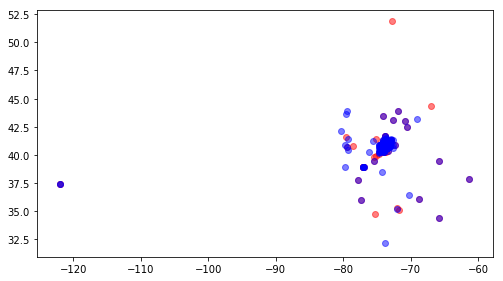

In [329]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)

plt.scatter(train['pickup_longitude'], train['pickup_latitude'], c='red', alpha=0.5)
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], c='blue', alpha=0.5)

#sns.regplot(x='pickup_longitude',y='pickup_latitude',data=combined,scatter=True, color='red', fit_reg=False, ax=ax1)
#sns.regplot(x='dropoff_longitude',y='dropoff_latitude',data=combined,scatter=True, color='blue', fit_reg=False, ax=ax1)


There are some extreme outliers in the location data. We need to remove them to make the predictions meaningful.

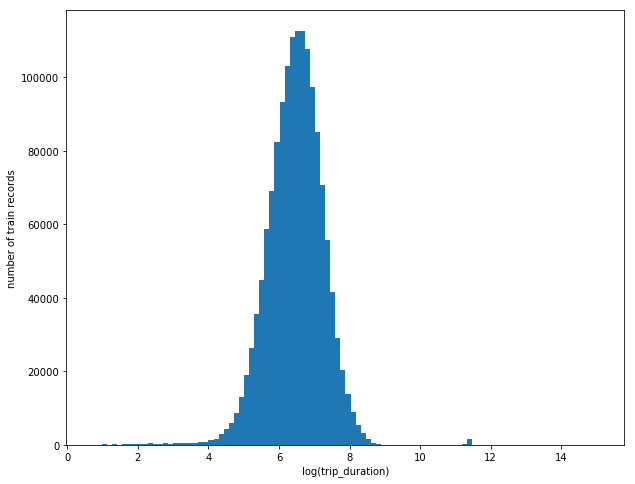

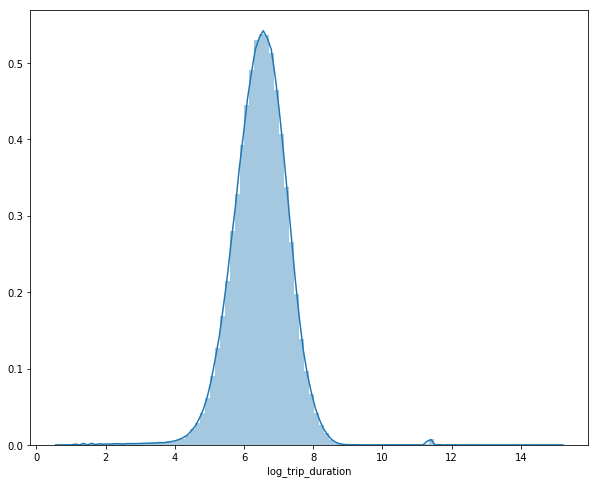

In [330]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

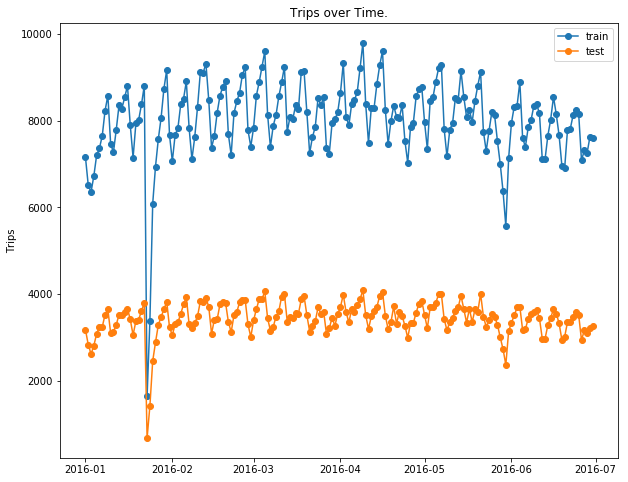

In [331]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

### 2.2 Clean data, remove outliers
### Distance outliers

The borders of NewYork City

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

In [332]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### Calculate Distance

In [333]:
#train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y':1 , 'N':0, 1:1, 0:0})
train['trip_distance'] = train.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)
test['trip_distance'] = test.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)

{'boxes': [<matplotlib.lines.Line2D at 0x1da82126ba8>],
 'caps': [<matplotlib.lines.Line2D at 0x1dadef96ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1dbaf7d57f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1db164f4ac8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1da82126278>,
  <matplotlib.lines.Line2D at 0x1db6e5d6e10>]}

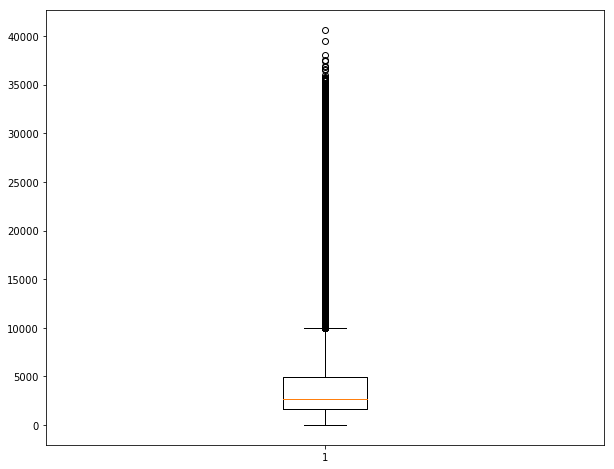

In [334]:
plt.boxplot(x=train['total_distance'], vert=True)

### Duration outliers

{'boxes': [<matplotlib.lines.Line2D at 0x1db3a2090f0>],
 'caps': [<matplotlib.lines.Line2D at 0x1db7c2be2b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1db7ba2a898>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1db7beb4fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1db9893e630>,
  <matplotlib.lines.Line2D at 0x1db7c2c5e10>]}

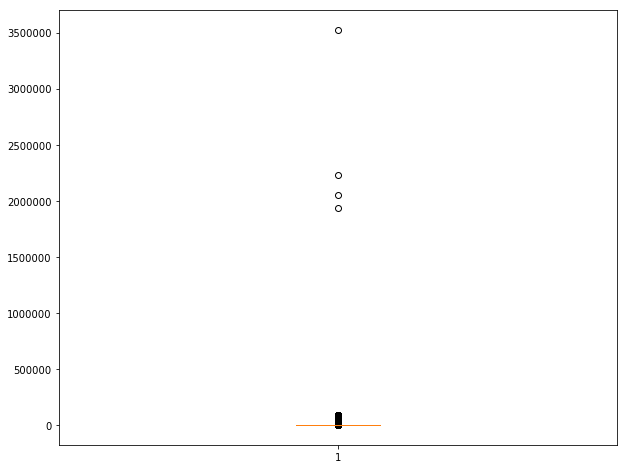

In [335]:
plt.boxplot(x=train['trip_duration'], vert=True)

Clearly there are some suspiciously long duration trips which need to be removed to have some meaningful analysis.

In [336]:
train = train[(train.trip_duration < 100000)]

{'boxes': [<matplotlib.lines.Line2D at 0x1da819003c8>],
 'caps': [<matplotlib.lines.Line2D at 0x1da81c26198>,
 'fliers': [<matplotlib.lines.Line2D at 0x1da81a857f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1da81a0fb70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1da8a2c3e10>,
  <matplotlib.lines.Line2D at 0x1daa4464da0>]}

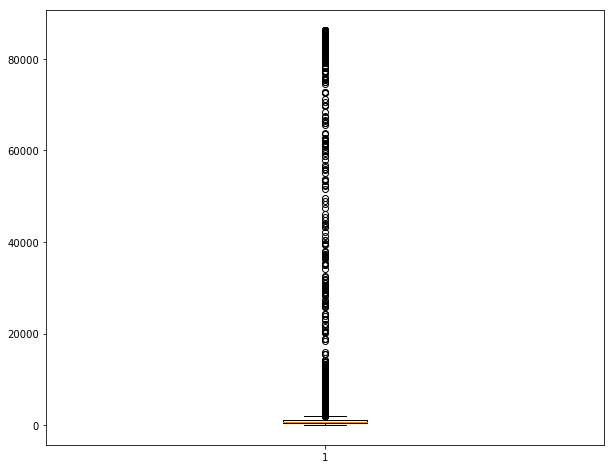

In [337]:
plt.boxplot(x=train['trip_duration'], vert=True)

Finally, the taxi trip distance gives us a normal distribution curve.

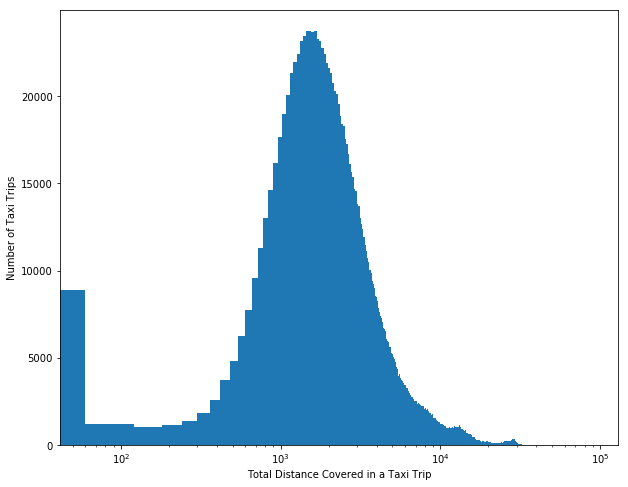

In [338]:
p = plt.hist(train['total_distance'], bins=1500, range=(0,90000))
plt.xlabel("Total Distance Covered in a Taxi Trip")
plt.ylabel("Number of Taxi Trips")
plt.xscale('log')

### 2.3 Feature engineering, date extraction

In [339]:
#Extracting Month
train['Month'] = pd.DatetimeIndex(pd.to_datetime(train['pickup_datetime'])).month
test['Month'] = pd.DatetimeIndex(pd.to_datetime(test['pickup_datetime'])).month

In [340]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226762
 2    235368
 3    252812
 4    248210
 5    244940
 6    231086
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [341]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [342]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [343]:
train['DayofWeek'] = train['pickup_datetime'].dt.dayofweek
test['DayofWeek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('DayofWeek').size()),len(test.groupby('DayofWeek').size())

(7, 7)

### Creating dummy variables

In [344]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
#passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
#passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['DayofWeek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['DayofWeek'], prefix='dow', prefix_sep='_')

In [345]:
train.passenger_count.describe()

count   1,439,178.000000000000000
mean            1.664766276304946
std             1.314838024473738
min             0.000000000000000
25%             1.000000000000000
50%             1.000000000000000
75%             2.000000000000000
max             6.000000000000000
Name: passenger_count, dtype: float64

In [346]:
test.passenger_count.describe()

count   625,134.000000000000000
mean          1.661765317515925
std           1.311292669267246
min           0.000000000000000
25%           1.000000000000000
50%           1.000000000000000
75%           2.000000000000000
max           9.000000000000000
Name: passenger_count, dtype: float64

### 2.4 Finding Data Correlations

### No. of taxi pickups over the various days

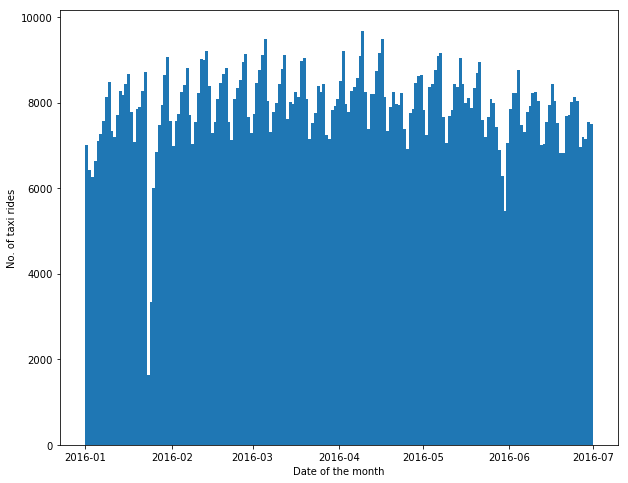

In [347]:
#combined.groupby(combined['pickup_datetime'].dt.month).count().plot(kind="bar")
#combined['pickup_datetime'].count()# .plot(kind="bar")
plt.hist(train.pickup_datetime.values, bins=182 )
plt.xlabel("Date of the month")
plt.ylabel("No. of taxi rides")

Some days of the year have exceptionally less number of taxi rides, possibly due to bad weather conditions. Introducing external weather data will be quite useful.

### No. of passengers related to taxi trip duration

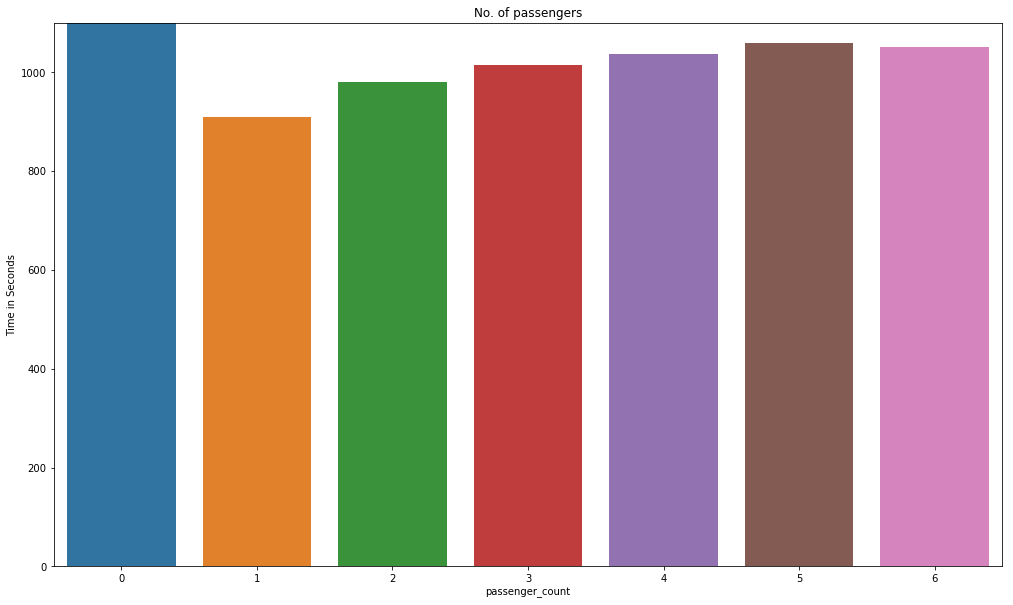

In [348]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('No. of passengers')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

### Hour of the day related to taxi trip duration

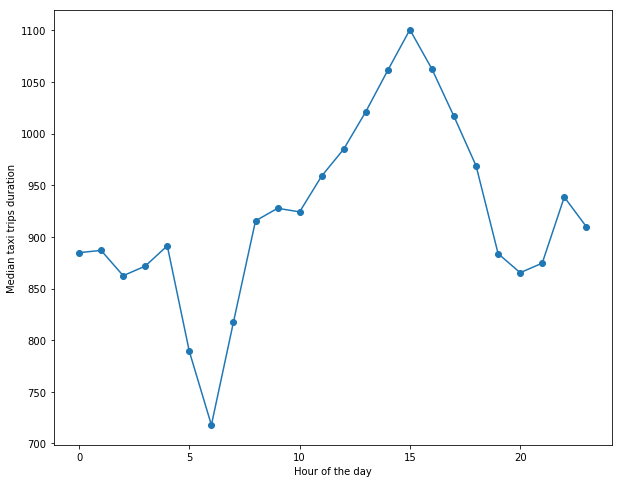

In [349]:
hr = train.groupby('Hour')['trip_duration'].mean()
plt.plot(hr, 'o-')
plt.xlabel("Hour of the day")
plt.ylabel("Median taxi trips duration")

This is definitely a very important feature to consider that not only affects the number of taxi trips but also the duration of those trips.

### Day of the week related to taxi trip durations

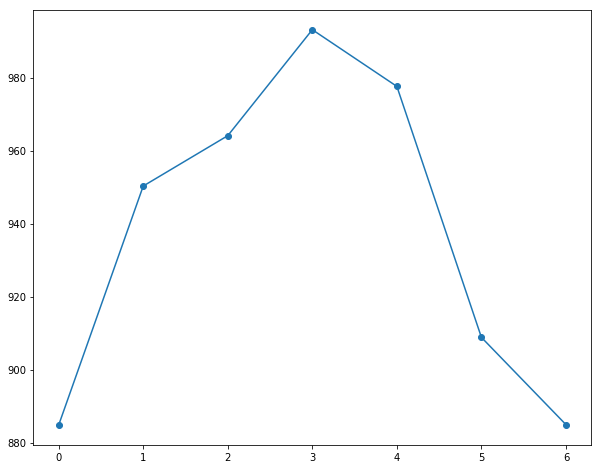

In [350]:
dwk = train.groupby('DayofWeek')['trip_duration'].mean()
plt.plot(dwk, 'o-')

Day of the week is definitely an important factor to consider while predicting the average taxi trip duration.

## 3. Modeling

### 3.1 Preparing the data

### Drop fields
Finally, drop the non-numeric columns in preparation for modeling and algorithm training.

In [351]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_distance,total_travel_time,number_of_steps,pickup_date,log_trip_duration,trip_distance,Month,DayofMonth,Hour,DayofWeek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,N,...,"2,009.099999999999909",164.900000000000006,5.000000000000000,2016-03-14,6.122492809514386,6421,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,N,...,"2,513.199999999999818",332.000000000000000,6.000000000000000,2016-06-12,6.498282149476434,7021,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,N,...,"11,060.799999999999272",767.600000000000023,16.000000000000000,2016-01-19,7.661527081358517,11062,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,N,...,"1,779.400000000000091",235.800000000000011,4.000000000000000,2016-04-06,6.063785208687608,1566,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,N,...,"1,614.900000000000091",140.099999999999994,5.000000000000000,2016-03-26,6.077642243349034,1082,3,26,13,5
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982856750488295,40.742195129394531,-73.992080688476562,40.749183654785156,N,...,"1,393.500000000000000",189.400000000000006,5.000000000000000,2016-01-30,6.095824562432225,3450,1,30,22,5
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017028808594,40.757839202880852,-73.957405090332031,40.765895843505852,N,...,"1,705.099999999999909",138.800000000000011,5.000000000000000,2016-06-17,5.834810737062605,4329,6,17,22,4
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276428222656,40.797779083251953,-73.922470092773438,40.760559082031250,N,...,"10,642.000000000000000",769.200000000000045,17.000000000000000,2016-05-21,7.347299700743164,17548,5,21,7,5
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481201171875,40.738399505615227,-73.985786437988295,40.732814788818359,N,...,"1,310.700000000000045",160.599999999999994,2.000000000000000,2016-05-27,5.545177444479562,5046,5,27,23,4
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981048583984375,40.744338989257812,-73.972999572753906,40.789989471435547,N,...,"6,786.800000000000182",601.799999999999955,13.000000000000000,2016-03-10,7.111512116496157,5476,3,10,21,3


In [352]:
test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,total_travel_time,number_of_steps,pickup_date,trip_distance,Month,DayofMonth,Hour,DayofWeek
0,id3004672,1,2016-06-30 23:59:58,1,-73.988128662109375,40.732028961181641,-73.990173339843750,40.756679534912102,N,"3,795.900000000000091",424.600000000000023,4,2016-06-30,2600,6,30,23,3
1,id3505355,1,2016-06-30 23:59:53,1,-73.964202880859375,40.679992675781250,-73.959808349609375,40.655403137207031,N,"2,904.500000000000000",200.000000000000000,4,2016-06-30,2963,6,30,23,3
2,id1217141,1,2016-06-30 23:59:47,1,-73.997436523437500,40.737583160400391,-73.986160278320298,40.729522705078132,N,"1,499.500000000000000",193.199999999999989,4,2016-06-30,4208,6,30,23,3
3,id2150126,2,2016-06-30 23:59:41,1,-73.956069946289062,40.771900177001953,-73.986427307128906,40.730468750000000,N,"7,023.899999999999636",494.800000000000011,11,2016-06-30,11879,6,30,23,3
4,id1598245,1,2016-06-30 23:59:33,1,-73.970214843750000,40.761474609375000,-73.961509704589844,40.755889892578132,N,"1,108.200000000000045",103.200000000000003,4,2016-06-30,3237,6,30,23,3
5,id0668992,1,2016-06-30 23:59:30,1,-73.991302490234375,40.749797821044922,-73.980514526367202,40.786548614501953,N,"5,841.399999999999636",441.100000000000023,15,2016-06-30,5422,6,30,23,3
6,id1765014,1,2016-06-30 23:59:15,1,-73.978309631347656,40.741550445556641,-73.952072143554688,40.717002868652337,N,"9,563.200000000000728",687.899999999999977,15,2016-06-30,9923,6,30,23,3
7,id0898117,1,2016-06-30 23:59:09,2,-74.012710571289062,40.701526641845696,-73.986480712890625,40.719509124755852,N,"3,786.199999999999818",489.199999999999989,12,2016-06-30,9774,6,30,23,3
8,id3905224,2,2016-06-30 23:58:55,2,-73.992332458496094,40.730510711669922,-73.875617980957017,40.875213623046882,N,"22,291.900000000001455","1,316.700000000000045",21,2016-06-30,45184,6,30,23,3
9,id1543102,2,2016-06-30 23:58:46,1,-73.993179321289062,40.748760223388672,-73.979309082031250,40.761310577392578,N,"2,128.800000000000182",245.500000000000000,3,2016-06-30,5234,6,30,23,3


In [353]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','DayofWeek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','DayofWeek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','trip_duration'], axis = 1)

### Add new fields

Now let's add the indicator variables to our datasets.

In [354]:
Train_Master = pd.concat([train,
                          vendor_train,
                          #passenger_count_train,
                          store_and_fwd_flag_train,
                          month_train,
                          dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

Test_Master = pd.concat([test, 
                         vendor_test,
                         #passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
                         hour_test,
                         dow_test
                        ], axis=1)

In [355]:
Train_Master.shape,Test_Master.shape

((1439178, 79), (625134, 78))

In [356]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_Master = Test_Master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [358]:
Train_Master.shape,Test_Master.shape

((1439178, 77), (625134, 76))

In [359]:
Train_Master.dtypes

total_distance       float64
total_travel_time    float64
number_of_steps      float64
log_trip_duration    float64
trip_distance          int32
vi_1                   uint8
vi_2                   uint8
sf_N                   uint8
sf_Y                   uint8
m_1                    uint8
m_2                    uint8
m_3                    uint8
m_4                    uint8
m_5                    uint8
m_6                    uint8
dom_1                  uint8
dom_2                  uint8
dom_3                  uint8
dom_4                  uint8
dom_5                  uint8
dom_6                  uint8
dom_7                  uint8
dom_8                  uint8
dom_9                  uint8
dom_10                 uint8
dom_11                 uint8
dom_12                 uint8
dom_13                 uint8
dom_14                 uint8
dom_15                 uint8
dom_16                 uint8
dom_17                 uint8
dom_18                 uint8
dom_19                 uint8
dom_20        

In [360]:
Test_Master.dtypes

total_distance       float64
total_travel_time    float64
number_of_steps        int64
trip_distance          int32
vi_1                   uint8
vi_2                   uint8
sf_N                   uint8
sf_Y                   uint8
m_1                    uint8
m_2                    uint8
m_3                    uint8
m_4                    uint8
m_5                    uint8
m_6                    uint8
dom_1                  uint8
dom_2                  uint8
dom_3                  uint8
dom_4                  uint8
dom_5                  uint8
dom_6                  uint8
dom_7                  uint8
dom_8                  uint8
dom_9                  uint8
dom_10                 uint8
dom_11                 uint8
dom_12                 uint8
dom_13                 uint8
dom_14                 uint8
dom_15                 uint8
dom_16                 uint8
dom_17                 uint8
dom_18                 uint8
dom_19                 uint8
dom_20                 uint8
dom_21        

In [361]:
Test_Master.dtypes, Train_Master.dtypes

(total_distance       float64
 total_travel_time    float64
 number_of_steps        int64
 trip_distance          int32
 vi_1                   uint8
 vi_2                   uint8
 sf_N                   uint8
 sf_Y                   uint8
 m_1                    uint8
 m_2                    uint8
 m_3                    uint8
 m_4                    uint8
 m_5                    uint8
 m_6                    uint8
 dom_1                  uint8
 dom_2                  uint8
 dom_3                  uint8
 dom_4                  uint8
 dom_5                  uint8
 dom_6                  uint8
 dom_7                  uint8
 dom_8                  uint8
 dom_9                  uint8
 dom_10                 uint8
 dom_11                 uint8
 dom_12                 uint8
 dom_13                 uint8
 dom_14                 uint8
 dom_15                 uint8
 dom_16                 uint8
 dom_17                 uint8
 dom_18                 uint8
 dom_19                 uint8
 dom_20   

### 3.2 Model training

### Train/Validation Split

In [362]:
Train, Valid = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [363]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_valid = Valid.drop(['log_trip_duration'], axis=1)
Y_valid = Valid["log_trip_duration"]

Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

### XGBoost setup

In [364]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(Test_Master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [269]:
md = [6]
lr = [.1,.3]
mcw = [20,25,30]

for m in md:
    for l in lr:
        for n in mcw:
            t0 = datetime.now()
            print(m,l,n)
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 'max_depth': m, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

In [370]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:5.4093	valid-rmse:5.41328
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.873	valid-rmse:4.87725
[2]	train-rmse:4.39075	valid-rmse:4.39527
[3]	train-rmse:3.95718	valid-rmse:3.96185
[4]	train-rmse:3.56758	valid-rmse:3.57258
[5]	train-rmse:3.21732	valid-rmse:3.22249
[6]	train-rmse:2.90265	valid-rmse:2.90804
[7]	train-rmse:2.62021	valid-rmse:2.62588
[8]	train-rmse:2.36676	valid-rmse:2.37267
[9]	train-rmse:2.13937	valid-rmse:2.14557
[10]	train-rmse:1.93569	valid-rmse:1.94207
[11]	train-rmse:1.75315	valid-rmse:1.75965
[12]	train-rmse:1.59	valid-rmse:1.59672
[13]	train-rmse:1.44428	valid-rmse:1.45133
[14]	train-rmse:1.3143	valid-rmse:1.32171
[15]	train-rmse:1.19861	valid-rmse:1.20625
[16]	train-rmse:1.09574	valid-rmse:1.10369
[17]	train-rmse:1.00464	valid-rmse:1.01296
[18]	train-rmse:0.924149	valid-rmse:0.932742
[19]	train-rmse:0.853122	valid-rmse:0.861994
[20]	tra

### Evaluation

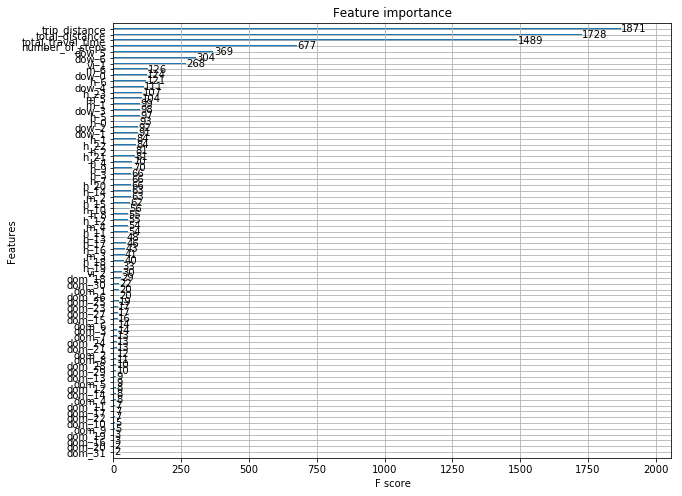

In [379]:
xgb.plot_importance(model, height=0.3)


### 3.3 Prediction and saving results

In [373]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

### Save CSV

In [375]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)